In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:90%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:10pt;}
div.text_cell_render.rendered_html{font-size:11pt;}
div.output {font-size:10pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:10pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:10pt;padding:5px;}
table.dataframe{font-size:10px;}
</style>
"""))

<b><font size="6" color="red">Ch 08. MNIST 손글씨 데이터 이미지 딥러닝 실습</font><b>

# 1. 데이터셋 라이브러리(/파일)에서 가져오기

In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import mnist # mnist 훈련셋/테스트셋
from tensorflow.keras.utils import to_categorical # 원핫인코딩
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Input, Dropout, LeakyReLU
from matplotlib import pyplot as plt

In [5]:
data = np.loadtxt('data/mnist_train_small.csv', delimiter=',', skiprows=1)
data.shape

(100, 785)

In [9]:
print('타겟 :', data[1,0])
#print('이미지(784pixel=28*28) :', data[1, 1:].reshape(28,28))
image = data[1, 1:].reshape(28,28)
image.shape

타겟 : 0.0


(28, 28)

In [10]:
for row in image:
    for pixel in row:
        print("{:3.0f}".format(pixel), end='')
    print()

  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 51159253159 50  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 48238252252252237  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 54227253252239233252 57  6  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0 10 60224252253252202 84252253122  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0163252252252253252252 96189253167  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0 51238253253190114253228 47 79255168  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0 48238252252179 12 75121 21  0  0253243 50  0  0  0  0  0
  0  0  0  0  0  0  0  0 38165253233208 84  0  0  0  0  0  025325

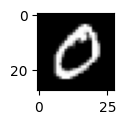

In [11]:
plt.figure(figsize=(1,1))
plt.imshow(image, cmap='gray')

In [12]:
%pip install opencv-python==4.8.1.78

   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   --- ------------------------------------ 3.4/38.1 MB 22.5 MB/s eta 0:00:02
   ------------ --------------------------- 11.8/38.1 MB 32.1 MB/s eta 0:00:01
   ----------------- ---------------------- 16.8/38.1 MB 29.4 MB/s eta 0:00:01
   ---------------------- ----------------- 21.8/38.1 MB 28.1 MB/s eta 0:00:01
   ---------------------------- ----------- 26.7/38.1 MB 27.3 MB/s eta 0:00:01
   ---------------------------------- ----- 33.3/38.1 MB 28.2 MB/s eta 0:00:01
   ---------------------------------------  38.0/38.1 MB 28.1 MB/s eta 0:00:01
   ---------------------------------------- 38.1/38.1 MB 27.2 MB/s  0:00:01
Note: you may need to restart the kernel to use updated packages.


In [19]:
import cv2
# 컬러 이미지 → 흑백 포맷으로 numpy array 읽기
image_gray = cv2.imread('data/go.jpg', cv2.IMREAD_GRAYSCALE)
image_gray.shape

(225, 225)

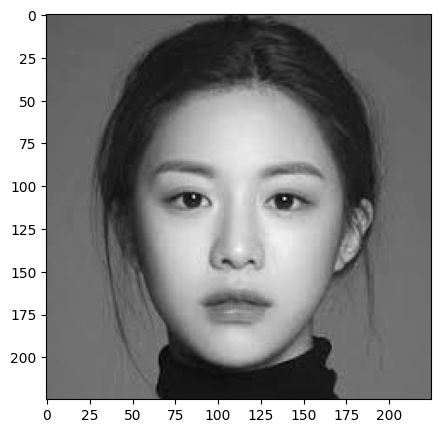

In [20]:
plt.figure(figsize=(5,5))
plt.imshow(image_gray, cmap='gray')

## 1.1. 데이터 생성 및 전처리

In [38]:
# 라이브러리에서 가져오기
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape
# 학습 전에 X는 2차원으로(60000, 784)로 reshape해야

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

2


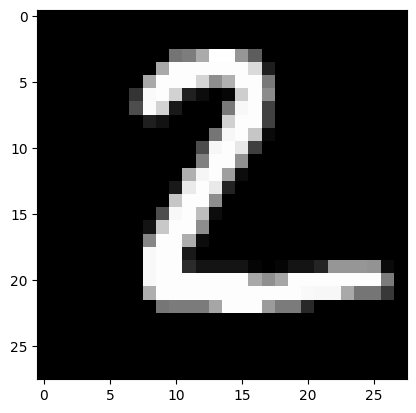

In [26]:
print(y_test[1])
plt.imshow(X_test[1], cmap='gray')
plt.show()
# for row in X_test[1]:
#     for pixel in row:
#         print("{:3.0f}".format(pixel), end='')
#     print()

In [39]:
# Train 데이터 6만 개 → Train(5만 개) + Val(1만 개)로 분리
X_val = X_train[50000:]
y_val = y_train[50000:]
X_train = X_train[:50000]
y_train = y_train[:50000]

In [40]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((50000, 28, 28), (50000,), (10000, 28, 28), (10000,))

In [41]:
# 입력(독립)변수 (n, 28, 28) → (n, 28*28) → 실수형 변환 → 스케일조정(/255)
train_X = X_train.reshape(50000, 28*28).astype('float32')/255.0
val_X = X_val.reshape(-1, 784).astype('float32')/255.0
test_X = X_test.reshape(10000, -1).astype('float32')/255.0
train_X.shape, val_X.shape, test_X.shape

((50000, 784), (10000, 784), (10000, 784))

In [43]:
# 분류분석을 위한 타깃변수의 원핫인코딩
train_Y = to_categorical(y_train, 10) # 10: 카테고리 수 (안 쓰면 자동 입력)
val_Y = to_categorical(y_val)
test_Y = to_categorical(y_test)
train_Y.shape, val_Y.shape, test_Y.shape

((50000, 10), (10000, 10), (10000, 10))

In [49]:
# Train 5만 → 700개, Val 1만 → 300개 (목적: 수업시간 중 fit 시간 절약)
train_idx = np.random.choice(50000, 700) # 0~50000 미만의 수 700개 뽑기
val_idx = np.random.choice(10000, 300)
train_X[train_idx].shape, val_X[val_idx].shape

((700, 784), (300, 784))

In [50]:
train_X = train_X[train_idx]
train_Y = train_Y[train_idx]
val_X = val_X[val_idx]
val_Y = val_Y[val_idx]

In [51]:
train_X.shape, val_X.shape, train_Y.shape, val_Y.shape, test_X.shape, test_Y.shape

((700, 784), (300, 784), (700, 10), (300, 10), (10000, 784), (10000, 10))

## 1.2. 모델 생성

In [52]:
model = Sequential()
model.add(Input(shape=(784,)))
model.add(Dense(units=2,
                #activation='relu'
               )) #Leakyrelu 사용 불가
model.add(LeakyReLU(alpha=0.01))
model.add(Dense(units=10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 1570      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                30        
                                                                 
Total params: 1,600
Trainable params: 1,600
Non-trainable params: 0
_________________________________________________________________


## 1.3. 학습과정 설정

In [53]:
model.compile(loss='categorical_crossentropy', #원핫인코딩 안 했을 때는 sparse_categorical_crossentropy (자동 원핫인코딩)
             optimizer='adam',
             metrics=['accuracy']) # 평가 지표

## 1.4. 모델 학습

In [54]:
%%time
hist = model.fit(train_X, train_Y, #학습셋
                epochs=200,
                batch_size=100,
                validation_data=(val_X, val_Y),
                verbose=0)

Epoch 1/200
7/7 [==============================] - 0s 24ms/step - loss: 2.2956 - accuracy: 0.1143 - val_loss: 2.2780 - val_accuracy: 0.1200
Epoch 2/200
7/7 [==============================] - 0s 6ms/step - loss: 2.2677 - accuracy: 0.1371 - val_loss: 2.2481 - val_accuracy: 0.1267
Epoch 3/200
7/7 [==============================] - 0s 5ms/step - loss: 2.2263 - accuracy: 0.1771 - val_loss: 2.1958 - val_accuracy: 0.1100
Epoch 4/200
7/7 [==============================] - 0s 3ms/step - loss: 2.1797 - accuracy: 0.1614 - val_loss: 2.1519 - val_accuracy: 0.1367
Epoch 5/200
7/7 [==============================] - 0s 5ms/step - loss: 2.1347 - accuracy: 0.1829 - val_loss: 2.1152 - val_accuracy: 0.1667
Epoch 6/200
7/7 [==============================] - 0s 5ms/step - loss: 2.0973 - accuracy: 0.2014 - val_loss: 2.0852 - val_accuracy: 0.1567
Epoch 7/200
7/7 [==============================] - 0s 7ms/step - loss: 2.0652 - accuracy: 0.2000 - val_loss: 2.0576 - val_accuracy: 0.1367
Epoch 8/200
7/7 [=========

7/7 [==============================] - 0s 6ms/step - loss: 1.5218 - accuracy: 0.4229 - val_loss: 1.5378 - val_accuracy: 0.3833
Epoch 60/200
7/7 [==============================] - 0s 5ms/step - loss: 1.5165 - accuracy: 0.4271 - val_loss: 1.5336 - val_accuracy: 0.3833
Epoch 61/200
7/7 [==============================] - 0s 5ms/step - loss: 1.5109 - accuracy: 0.4314 - val_loss: 1.5302 - val_accuracy: 0.3967
Epoch 62/200
7/7 [==============================] - 0s 5ms/step - loss: 1.5047 - accuracy: 0.4329 - val_loss: 1.5224 - val_accuracy: 0.3900
Epoch 63/200
7/7 [==============================] - 0s 5ms/step - loss: 1.4996 - accuracy: 0.4357 - val_loss: 1.5173 - val_accuracy: 0.4000
Epoch 64/200
7/7 [==============================] - 0s 5ms/step - loss: 1.4938 - accuracy: 0.4371 - val_loss: 1.5148 - val_accuracy: 0.4067
Epoch 65/200
7/7 [==============================] - 0s 5ms/step - loss: 1.4888 - accuracy: 0.4357 - val_loss: 1.5099 - val_accuracy: 0.3967
Epoch 66/200
7/7 [===============

7/7 [==============================] - 0s 5ms/step - loss: 1.2668 - accuracy: 0.5300 - val_loss: 1.3470 - val_accuracy: 0.4833
Epoch 118/200
7/7 [==============================] - 0s 5ms/step - loss: 1.2627 - accuracy: 0.5329 - val_loss: 1.3447 - val_accuracy: 0.4867
Epoch 119/200
7/7 [==============================] - 0s 5ms/step - loss: 1.2591 - accuracy: 0.5414 - val_loss: 1.3421 - val_accuracy: 0.5000
Epoch 120/200
7/7 [==============================] - 0s 5ms/step - loss: 1.2560 - accuracy: 0.5414 - val_loss: 1.3418 - val_accuracy: 0.4867
Epoch 121/200
7/7 [==============================] - 0s 5ms/step - loss: 1.2529 - accuracy: 0.5429 - val_loss: 1.3374 - val_accuracy: 0.4967
Epoch 122/200
7/7 [==============================] - 0s 5ms/step - loss: 1.2493 - accuracy: 0.5457 - val_loss: 1.3369 - val_accuracy: 0.4967
Epoch 123/200
7/7 [==============================] - 0s 5ms/step - loss: 1.2469 - accuracy: 0.5429 - val_loss: 1.3358 - val_accuracy: 0.4867
Epoch 124/200
7/7 [========

7/7 [==============================] - 0s 5ms/step - loss: 1.1065 - accuracy: 0.6000 - val_loss: 1.2734 - val_accuracy: 0.4933
Epoch 176/200
7/7 [==============================] - 0s 5ms/step - loss: 1.1061 - accuracy: 0.6014 - val_loss: 1.2738 - val_accuracy: 0.5067
Epoch 177/200
7/7 [==============================] - 0s 5ms/step - loss: 1.1028 - accuracy: 0.5986 - val_loss: 1.2757 - val_accuracy: 0.5133
Epoch 178/200
7/7 [==============================] - 0s 5ms/step - loss: 1.1012 - accuracy: 0.5971 - val_loss: 1.2752 - val_accuracy: 0.5133
Epoch 179/200
7/7 [==============================] - 0s 5ms/step - loss: 1.0986 - accuracy: 0.6014 - val_loss: 1.2728 - val_accuracy: 0.5233
Epoch 180/200
7/7 [==============================] - 0s 3ms/step - loss: 1.0962 - accuracy: 0.6014 - val_loss: 1.2719 - val_accuracy: 0.5100
Epoch 181/200
7/7 [==============================] - 0s 3ms/step - loss: 1.0940 - accuracy: 0.6129 - val_loss: 1.2729 - val_accuracy: 0.5200
Epoch 182/200
7/7 [========

## 1.5. 모델 평가하기

In [55]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

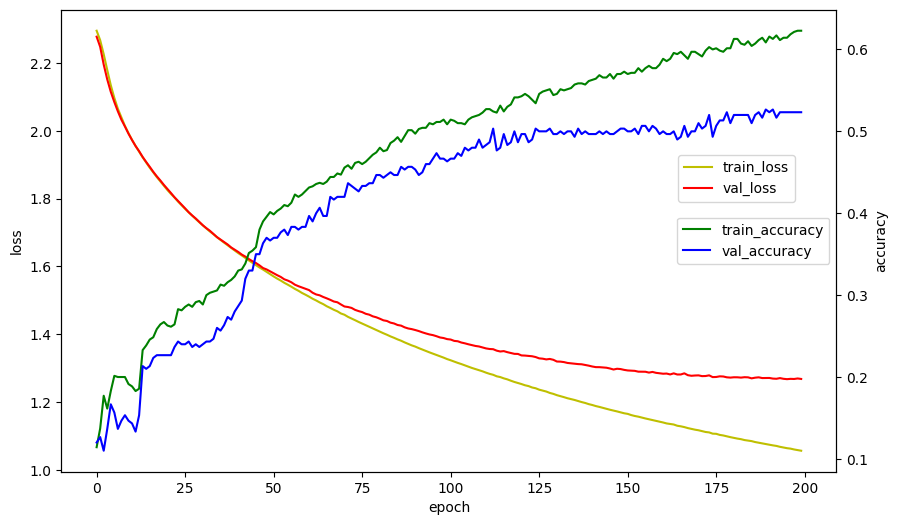

In [56]:
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [59]:
# 모델 평가 (테스트셋)
loss_metrics = model.evaluate(test_X, test_Y, batch_size=100, verbose=0)
print('loss: ', loss_metrics[0])
print('accuracy: ', loss_metrics[1])

loss:  1.4340639114379883
accuracy:  0.49630001187324524


# 📌 위 모델(DNN)의 accuracy 늘리기
1. 학습 데이터 절대량 확보 (가장 효과적)
2. 모델 보완 : 레이어 추가, units 수 증가 / 과하면 과적합 우려
3. 과적합 방지(validation data 추가, 활성화 함수(relu 계열, tanh), Dropout) 
4. epochs 조정
5. optimizer 변경 (영향 미비)

In [60]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_val = X_train[50000:]
y_val = y_train[50000:]
X_train = X_train[:50000]
y_train = y_train[:50000]

train_X = X_train.reshape(50000, 28*28).astype('float32')/255.0
val_X = X_val.reshape(-1, 784).astype('float32')/255.0
test_X = X_test.reshape(10000, -1).astype('float32')/255.0

train_Y = to_categorical(y_train, 10)
val_Y = to_categorical(y_val)
test_Y = to_categorical(y_test)

model = Sequential()
model.add(Input(shape=(784,)))
model.add(Dense(units=2,))
model.add(LeakyReLU(alpha=0.01))
model.add(Dense(units=10, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 2)                 1570      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 2)                 0         
                                                                 
 dense_3 (Dense)             (None, 10)                30        
                                                                 
Total params: 1,600
Trainable params: 1,600
Non-trainable params: 0
_________________________________________________________________


In [61]:
%%time
hist = model.fit(train_X, train_Y, #학습셋
                epochs=200,
                batch_size=100,
                validation_data=(val_X, val_Y),
                verbose=0)

CPU times: total: 2min 31s
Wall time: 1min 42s


In [62]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

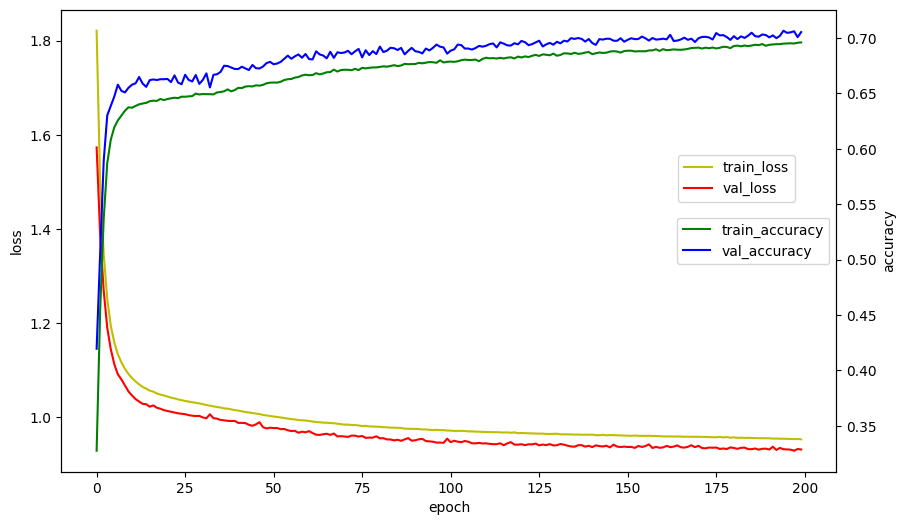

In [63]:
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [65]:
model.evaluate(test_X, test_Y)

313/313 [==============================] - 0s 736us/step - loss: 0.9896 - accuracy: 0.6910


[0.9895628690719604, 0.6909999847412109]

In [66]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_val = X_train[50000:]
y_val = y_train[50000:]
X_train = X_train[:50000]
y_train = y_train[:50000]

train_X = X_train.reshape(50000, 28*28).astype('float32')/255.0
val_X = X_val.reshape(-1, 784).astype('float32')/255.0
test_X = X_test.reshape(10000, -1).astype('float32')/255.0

train_Y = to_categorical(y_train, 10)
val_Y = to_categorical(y_val)
test_Y = to_categorical(y_test)

model2 = Sequential()
model2.add(Input(shape=(784,)))
model2.add(Dense(units=1024))
model2.add(LeakyReLU(alpha=0.01))
model2.add(Dropout(0.2))
model2.add(Dense(units=512))
model2.add(LeakyReLU(alpha=0.01))
model2.add(Dropout(0.2))
model2.add(Dense(units=128))
model2.add(LeakyReLU(alpha=0.01))
model2.add(Dropout(0.2))
model2.add(Dense(units=10, activation='softmax'))
model2.summary()

model2.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              803840    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [67]:
%%time
hist = model2.fit(train_X, train_Y, #학습셋
                epochs=20,
                batch_size=100,
                validation_data=(val_X, val_Y),
                verbose=1)

Epoch 1/20
500/500 [==============================] - 4s 8ms/step - loss: 0.2655 - accuracy: 0.9188 - val_loss: 0.1163 - val_accuracy: 0.9648
Epoch 2/20
500/500 [==============================] - 4s 8ms/step - loss: 0.1131 - accuracy: 0.9665 - val_loss: 0.0871 - val_accuracy: 0.9745
Epoch 3/20
500/500 [==============================] - 4s 8ms/step - loss: 0.0785 - accuracy: 0.9763 - val_loss: 0.0851 - val_accuracy: 0.9752
Epoch 4/20
500/500 [==============================] - 4s 8ms/step - loss: 0.0656 - accuracy: 0.9800 - val_loss: 0.0904 - val_accuracy: 0.9727
Epoch 5/20
500/500 [==============================] - 4s 8ms/step - loss: 0.0544 - accuracy: 0.9831 - val_loss: 0.0734 - val_accuracy: 0.9799
Epoch 6/20
500/500 [==============================] - 4s 8ms/step - loss: 0.0487 - accuracy: 0.9843 - val_loss: 0.0760 - val_accuracy: 0.9785
Epoch 7/20
500/500 [==============================] - 4s 8ms/step - loss: 0.0403 - accuracy: 0.9870 - val_loss: 0.0897 - val_accuracy: 0.9774
Epoch 

In [71]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

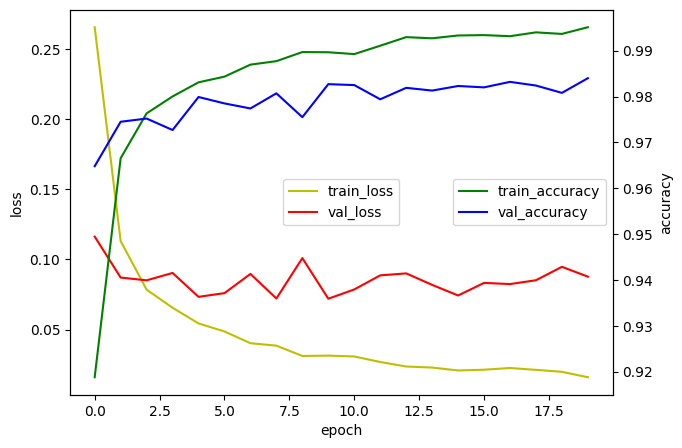

In [73]:
fig, loss_ax = plt.subplots(figsize=(7,5))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center')
acc_ax.legend(loc='center right')
plt.show()

In [83]:
score = model2.evaluate(test_X, test_Y)

313/313 [==============================] - 1s 3ms/step - loss: 0.0885 - accuracy: 0.9818


In [76]:
#교차표
np.all(test_Y.argmax(axis=1) == y_test) # 실제값 y_test

True

In [79]:
# model2.predict(test_X).argmax(axis=1)
y_hat = np.argmax(model2.predict(test_X), axis=1) # 예측값 y_hat

313/313 [==============================] - 1s 3ms/step


In [81]:
pd.crosstab(y_test, y_hat, rownames=['실제값'], colnames=['예측값'])

예측값,0,1,2,3,4,5,6,7,8,9
실제값,,,,,,,,,,
0,971,1,0,1,0,0,5,1,1,0
1,0,1128,2,0,0,1,2,0,2,0
2,1,0,1015,2,2,0,2,8,2,0
3,0,0,3,998,0,2,0,3,3,1
4,0,2,2,0,963,0,4,1,0,10
5,1,0,0,7,1,870,7,0,4,2
6,3,4,0,0,3,3,943,0,2,0
7,0,4,7,1,0,0,0,1009,2,5
8,5,0,3,4,9,2,1,2,942,6


In [84]:
# 틀린 갯수
10000-10000*score[1]

181.9998025894165

# 📞 콜백함수 1: Callback - 로그 출력

In [85]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

In [86]:
%%time
#특정 epoch마다 로그 출력하도록 제한

class CustomHistory(Callback):
    def __init__(self): #생성자함수
        self.epoch = 0
    def on_epoch_end(self, batch, logs={}):
        '1 epoch마다 자동 실행되는 함수'
        self.epoch += 1
        if self.epoch%10 == 0:
            print('epoch: {}, loss: {:.4f}, acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.format(
                    self.epoch, logs.get('loss'), logs.get('accuracy', '-'), 
                    logs.get('val_loss', '-'), logs.get('val_accuracy', '-')))

customHistory = CustomHistory()
        
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_val = X_train[50000:]
y_val = y_train[50000:]
X_train = X_train[:50000]
y_train = y_train[:50000]

train_X = X_train.reshape(50000, 28*28).astype('float32')/255.0
val_X = X_val.reshape(-1, 784).astype('float32')/255.0
test_X = X_test.reshape(10000, -1).astype('float32')/255.0

train_Y = to_categorical(y_train, 10)
val_Y = to_categorical(y_val)
test_Y = to_categorical(y_test)

train_idx = np.random.choice(50000, 700)
val_idx = np.random.choice(10000, 300)
train_X = train_X[train_idx]
train_Y = train_Y[train_idx]
val_X = val_X[val_idx]
val_Y = val_Y[val_idx]

model3 = Sequential()
model3.add(Input(shape=(784,)))
model3.add(Dense(units=2, activation='relu'))
model3.add(Dense(units=10, activation='softmax'))
model3.summary()

model3.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

hist = model3.fit(train_X, train_Y,
                  epochs=50,
                  batch_size=100,
                  validation_data=(val_X, val_Y),
                  verbose=0,
                  callbacks=[customHistory]) #콜백함수

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 2)                 1570      
                                                                 
 dense_9 (Dense)             (None, 10)                30        
                                                                 
Total params: 1,600
Trainable params: 1,600
Non-trainable params: 0
_________________________________________________________________
epoch: 10, loss: 1.9805, acc: 0.2214, val_loss: 1.9766, val_acc: 0.2500
epoch: 20, loss: 1.8308, acc: 0.2600, val_loss: 1.8527, val_acc: 0.2700
epoch: 30, loss: 1.7254, acc: 0.3300, val_loss: 1.7843, val_acc: 0.3167
epoch: 40, loss: 1.6383, acc: 0.4057, val_loss: 1.7354, val_acc: 0.3433
epoch: 50, loss: 1.5674, acc: 0.4357, val_loss: 1.6954, val_acc: 0.3800
CPU times: total: 2.27 s
Wall time: 1.98 s


# 📞 콜백함수 2: EarlyStopping
- val_loss 값이 늘어나면 지정한 epoch를 다 수행하지 않고 조기에 종료
- val_accuracy 값이 감소하면 지정한 epoch를 다 수행하지 않고 조기에 종료

In [90]:
%%time
#특정 epoch마다 로그 출력하도록 제한

class CustomHistory(Callback):
    def __init__(self): #생성자함수
        self.epoch = 0
    def on_epoch_end(self, batch, logs={}):
        '1 epoch마다 자동 실행되는 함수'
        self.epoch += 1
        if self.epoch%10 == 0:
            print('epoch: {}, loss: {:.4f}, acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.format(
                    self.epoch, logs.get('loss'), logs.get('accuracy', '-'), 
                    logs.get('val_loss', '-'), logs.get('val_accuracy', '-')))

customHistory = CustomHistory()
        
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_val = X_train[50000:]
y_val = y_train[50000:]
X_train = X_train[:50000]
y_train = y_train[:50000]

train_X = X_train.reshape(50000, 28*28).astype('float32')/255.0
val_X = X_val.reshape(-1, 784).astype('float32')/255.0
test_X = X_test.reshape(10000, -1).astype('float32')/255.0

train_Y = to_categorical(y_train, 10)
val_Y = to_categorical(y_val)
test_Y = to_categorical(y_test)

train_idx = np.random.choice(50000, 700)
val_idx = np.random.choice(10000, 300)
train_X = train_X[train_idx]
train_Y = train_Y[train_idx]
val_X = val_X[val_idx]
val_Y = val_Y[val_idx]

model3 = Sequential()
model3.add(Input(shape=(784,)))
model3.add(Dense(units=2, activation='relu'))
model3.add(Dense(units=10, activation='softmax'))
model3.summary()

model3.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# monitor 기준으로 patience회 이상 안 좋은 데이터가 나오면 조기 종료
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=10)

hist = model3.fit(train_X, train_Y,
                  epochs=500,
                  batch_size=100,
                  validation_data=(val_X, val_Y),
                  verbose=1,
                  callbacks=[earlyStopping]) #콜백함수

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 2)                 1570      
                                                                 
 dense_17 (Dense)            (None, 10)                30        
                                                                 
Total params: 1,600
Trainable params: 1,600
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
7/7 [==============================] - 0s 18ms/step - loss: 2.3020 - accuracy: 0.1186 - val_loss: 2.2959 - val_accuracy: 0.1033
Epoch 2/500
7/7 [==============================] - 0s 6ms/step - loss: 2.2588 - accuracy: 0.1371 - val_loss: 2.2725 - val_accuracy: 0.1067
Epoch 3/500
7/7 [==============================] - 0s 7ms/step - loss: 2.2171 - accuracy: 0.1500 - val_loss: 2.2447 - val_accuracy: 0.1200
Epoch 4/500
7/7 [=============

Epoch 55/500
7/7 [==============================] - 0s 5ms/step - loss: 1.5298 - accuracy: 0.4329 - val_loss: 1.6597 - val_accuracy: 0.3833
Epoch 56/500
7/7 [==============================] - 0s 5ms/step - loss: 1.5243 - accuracy: 0.4386 - val_loss: 1.6542 - val_accuracy: 0.3900
Epoch 57/500
7/7 [==============================] - 0s 5ms/step - loss: 1.5187 - accuracy: 0.4386 - val_loss: 1.6497 - val_accuracy: 0.3900
Epoch 58/500
7/7 [==============================] - 0s 5ms/step - loss: 1.5138 - accuracy: 0.4414 - val_loss: 1.6452 - val_accuracy: 0.3867
Epoch 59/500
7/7 [==============================] - 0s 5ms/step - loss: 1.5079 - accuracy: 0.4414 - val_loss: 1.6410 - val_accuracy: 0.3933
Epoch 60/500
7/7 [==============================] - 0s 5ms/step - loss: 1.5027 - accuracy: 0.4429 - val_loss: 1.6364 - val_accuracy: 0.3967
Epoch 61/500
7/7 [==============================] - 0s 5ms/step - loss: 1.4982 - accuracy: 0.4471 - val_loss: 1.6312 - val_accuracy: 0.4067
Epoch 62/500
7/7 [==

# 📞 콜백함수 3: ModelCheckpoint
- epoch마다 val_accuracy(val_loss, accuracy, loss)값이 좋을 때 모델을 자동 저장하는 콜백

In [93]:
# 모델
model = Sequential()
model.add(Input(shape=(784,)))
model.add(Dense(units=2, activation='relu'))
model.add(Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy', # sparse_categorical_crossentropy
             optimizer='adam',
             metrics=['accuracy'])# 평가지표
# 모델 자동 자정 콜백
import os
model_save_folder = './model08/'
if not os.path.exists(model_save_folder): # 폴더가 없으면 폴더 생성
    os.mkdir(model_save_folder)
file = model_save_folder + 'mnist-{epoch:03d}-val{val_accuracy:.4f}.h5'
checkpoint = ModelCheckpoint(
                filepath = file,
                monitor='val_accuracy', #모니터할 지표(기본값 val_loss)
                save_best_only=True,    # 모니터링 지표가 개선된 경우만 저장
                mode = 'max', # 값이 클수록 저장
                verbose=1
)

hist = model.fit(train_X, train_Y, # 학습셋
                epochs=200,
                batch_size=100,
                validation_data=(val_X, val_Y),
                verbose=1,
                callbacks=[checkpoint]) # 콜백함수

Epoch 1/200
1/7 [===>..........................] - ETA: 1s - loss: 2.3073 - accuracy: 0.0900
Epoch 1: val_accuracy improved from -inf to 0.16667, saving model to ./model08\mnist-001-val0.1667.h5
7/7 [==============================] - 0s 23ms/step - loss: 2.3052 - accuracy: 0.1243 - val_loss: 2.2797 - val_accuracy: 0.1667
Epoch 2/200
1/7 [===>..........................] - ETA: 0s - loss: 2.2830 - accuracy: 0.1700
Epoch 2: val_accuracy improved from 0.16667 to 0.17667, saving model to ./model08\mnist-002-val0.1767.h5
7/7 [==============================] - 0s 6ms/step - loss: 2.2644 - accuracy: 0.1814 - val_loss: 2.2351 - val_accuracy: 0.1767
Epoch 3/200
1/7 [===>..........................] - ETA: 0s - loss: 2.2149 - accuracy: 0.1900
Epoch 3: val_accuracy did not improve from 0.17667
7/7 [==============================] - 0s 7ms/step - loss: 2.2154 - accuracy: 0.1657 - val_loss: 2.1874 - val_accuracy: 0.1700
Epoch 4/200
1/7 [===>..........................] - ETA: 0s - loss: 2.1950 - accur

1/7 [===>..........................] - ETA: 0s - loss: 1.7364 - accuracy: 0.3000
Epoch 27: val_accuracy did not improve from 0.31333
7/7 [==============================] - 0s 7ms/step - loss: 1.7731 - accuracy: 0.2929 - val_loss: 1.7963 - val_accuracy: 0.3100
Epoch 28/200
1/7 [===>..........................] - ETA: 0s - loss: 1.8028 - accuracy: 0.2500
Epoch 28: val_accuracy improved from 0.31333 to 0.32333, saving model to ./model08\mnist-028-val0.3233.h5
7/7 [==============================] - 0s 7ms/step - loss: 1.7643 - accuracy: 0.2986 - val_loss: 1.7868 - val_accuracy: 0.3233
Epoch 29/200
1/7 [===>..........................] - ETA: 0s - loss: 1.7603 - accuracy: 0.2900
Epoch 29: val_accuracy did not improve from 0.32333
7/7 [==============================] - 0s 6ms/step - loss: 1.7555 - accuracy: 0.3043 - val_loss: 1.7826 - val_accuracy: 0.3233
Epoch 30/200
1/7 [===>..........................] - ETA: 0s - loss: 1.7987 - accuracy: 0.2400
Epoch 30: val_accuracy did not improve from 0.

1/7 [===>..........................] - ETA: 0s - loss: 1.6006 - accuracy: 0.4100
Epoch 55: val_accuracy did not improve from 0.37667
7/7 [==============================] - 0s 5ms/step - loss: 1.6026 - accuracy: 0.4114 - val_loss: 1.6729 - val_accuracy: 0.3700
Epoch 56/200
1/7 [===>..........................] - ETA: 0s - loss: 1.6078 - accuracy: 0.3500
Epoch 56: val_accuracy did not improve from 0.37667
7/7 [==============================] - 0s 4ms/step - loss: 1.5979 - accuracy: 0.4100 - val_loss: 1.6732 - val_accuracy: 0.3733
Epoch 57/200
1/7 [===>..........................] - ETA: 0s - loss: 1.6288 - accuracy: 0.3700
Epoch 57: val_accuracy improved from 0.37667 to 0.38000, saving model to ./model08\mnist-057-val0.3800.h5
7/7 [==============================] - 0s 9ms/step - loss: 1.5935 - accuracy: 0.4214 - val_loss: 1.6699 - val_accuracy: 0.3800
Epoch 58/200
1/7 [===>..........................] - ETA: 0s - loss: 1.5581 - accuracy: 0.4500
Epoch 58: val_accuracy did not improve from 0.

1/7 [===>..........................] - ETA: 0s - loss: 1.5889 - accuracy: 0.4500
Epoch 84: val_accuracy did not improve from 0.39667
7/7 [==============================] - 0s 6ms/step - loss: 1.4929 - accuracy: 0.4614 - val_loss: 1.6136 - val_accuracy: 0.3967
Epoch 85/200
1/7 [===>..........................] - ETA: 0s - loss: 1.5092 - accuracy: 0.4500
Epoch 85: val_accuracy did not improve from 0.39667
7/7 [==============================] - 0s 6ms/step - loss: 1.4898 - accuracy: 0.4657 - val_loss: 1.6104 - val_accuracy: 0.3967
Epoch 86/200
1/7 [===>..........................] - ETA: 0s - loss: 1.6165 - accuracy: 0.4300
Epoch 86: val_accuracy improved from 0.39667 to 0.40000, saving model to ./model08\mnist-086-val0.4000.h5
7/7 [==============================] - 0s 8ms/step - loss: 1.4866 - accuracy: 0.4743 - val_loss: 1.6084 - val_accuracy: 0.4000
Epoch 87/200
1/7 [===>..........................] - ETA: 0s - loss: 1.5024 - accuracy: 0.4900
Epoch 87: val_accuracy did not improve from 0.

Epoch 113/200
1/7 [===>..........................] - ETA: 0s - loss: 1.4021 - accuracy: 0.5700
Epoch 113: val_accuracy did not improve from 0.43000
7/7 [==============================] - 0s 5ms/step - loss: 1.4059 - accuracy: 0.5214 - val_loss: 1.5721 - val_accuracy: 0.4300
Epoch 114/200
1/7 [===>..........................] - ETA: 0s - loss: 1.3007 - accuracy: 0.6100
Epoch 114: val_accuracy did not improve from 0.43000
7/7 [==============================] - 0s 5ms/step - loss: 1.4028 - accuracy: 0.5229 - val_loss: 1.5717 - val_accuracy: 0.4267
Epoch 115/200
1/7 [===>..........................] - ETA: 0s - loss: 1.4819 - accuracy: 0.5400
Epoch 115: val_accuracy did not improve from 0.43000
7/7 [==============================] - 0s 5ms/step - loss: 1.3997 - accuracy: 0.5257 - val_loss: 1.5690 - val_accuracy: 0.4233
Epoch 116/200
1/7 [===>..........................] - ETA: 0s - loss: 1.4118 - accuracy: 0.5700
Epoch 116: val_accuracy did not improve from 0.43000
7/7 [======================

Epoch 141/200
1/7 [===>..........................] - ETA: 0s - loss: 1.3604 - accuracy: 0.5200
Epoch 141: val_accuracy did not improve from 0.49333
7/7 [==============================] - 0s 5ms/step - loss: 1.3138 - accuracy: 0.5757 - val_loss: 1.5199 - val_accuracy: 0.4933
Epoch 142/200
1/7 [===>..........................] - ETA: 0s - loss: 1.2368 - accuracy: 0.6300
Epoch 142: val_accuracy did not improve from 0.49333
7/7 [==============================] - 0s 5ms/step - loss: 1.3097 - accuracy: 0.5829 - val_loss: 1.5236 - val_accuracy: 0.4867
Epoch 143/200
1/7 [===>..........................] - ETA: 0s - loss: 1.4438 - accuracy: 0.5200
Epoch 143: val_accuracy did not improve from 0.49333
7/7 [==============================] - 0s 5ms/step - loss: 1.3063 - accuracy: 0.5843 - val_loss: 1.5197 - val_accuracy: 0.4933
Epoch 144/200
1/7 [===>..........................] - ETA: 0s - loss: 1.2734 - accuracy: 0.6000
Epoch 144: val_accuracy did not improve from 0.49333
7/7 [======================

Epoch 171/200
1/7 [===>..........................] - ETA: 0s - loss: 1.2116 - accuracy: 0.6200
Epoch 171: val_accuracy did not improve from 0.49667
7/7 [==============================] - 0s 5ms/step - loss: 1.2125 - accuracy: 0.6071 - val_loss: 1.4748 - val_accuracy: 0.4933
Epoch 172/200
1/7 [===>..........................] - ETA: 0s - loss: 1.2212 - accuracy: 0.6100
Epoch 172: val_accuracy did not improve from 0.49667
7/7 [==============================] - 0s 6ms/step - loss: 1.2101 - accuracy: 0.6071 - val_loss: 1.4759 - val_accuracy: 0.4867
Epoch 173/200
1/7 [===>..........................] - ETA: 0s - loss: 1.2595 - accuracy: 0.6000
Epoch 173: val_accuracy did not improve from 0.49667
7/7 [==============================] - 0s 6ms/step - loss: 1.2070 - accuracy: 0.6057 - val_loss: 1.4735 - val_accuracy: 0.4900
Epoch 174/200
1/7 [===>..........................] - ETA: 0s - loss: 1.1983 - accuracy: 0.5400
Epoch 174: val_accuracy did not improve from 0.49667
7/7 [======================